## Diary data from assets through API's, with the use of 'pandas_datareader' library.

### https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

### https://finance.yahoo.com

c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas_datareader\_utils.py:37: UserWarning: Parsing '30-09-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  end = to_datetime(end)


<AxesSubplot:xlabel='Date'>

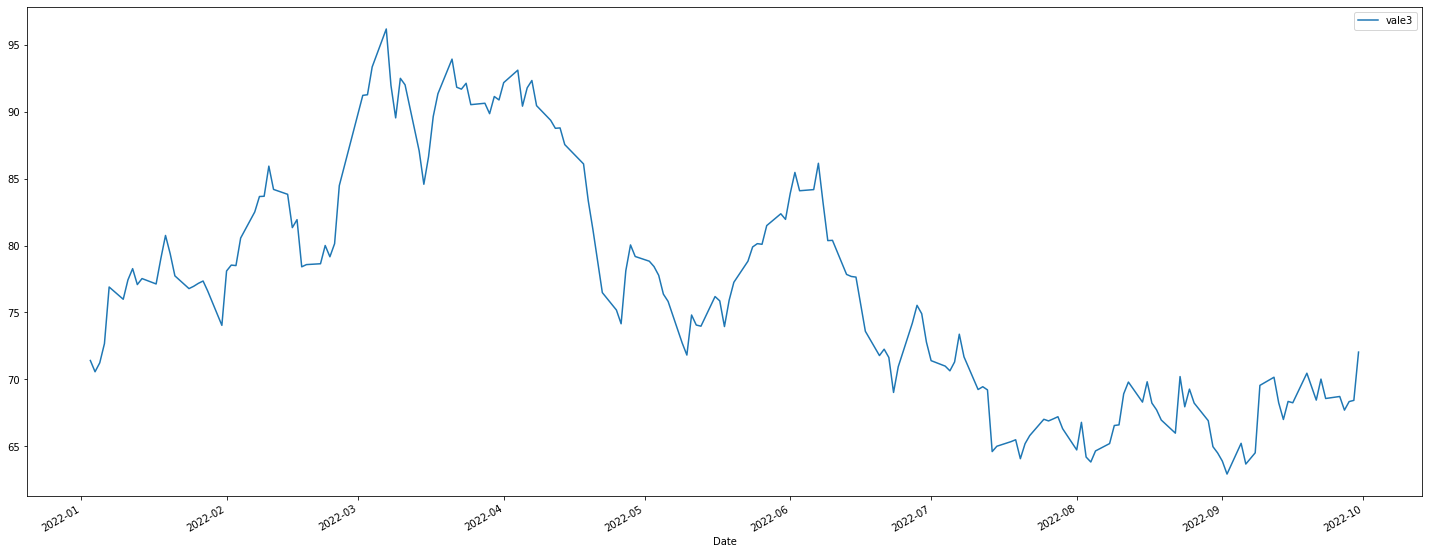

In [2]:
# Since the development of this notebook, the Yahoo API has suffered some alterations in it's usage. That may result in ocasional errors during the rerun of this notebook. 

from tracemalloc import start
from pandas_datareader import data as web
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dt_start='01-01-2022'
dt_end='30-09-2022'

asset_yahoo = pd.DataFrame()
asset_yahoo["vale3"] = web.DataReader('vale3.SA', data_source='yahoo', start=dt_start, end=dt_end)["Adj Close"]

#display(cotacao_yahoo)

asset_yahoo.plot(figsize=(25,10))

# Correlation matrix

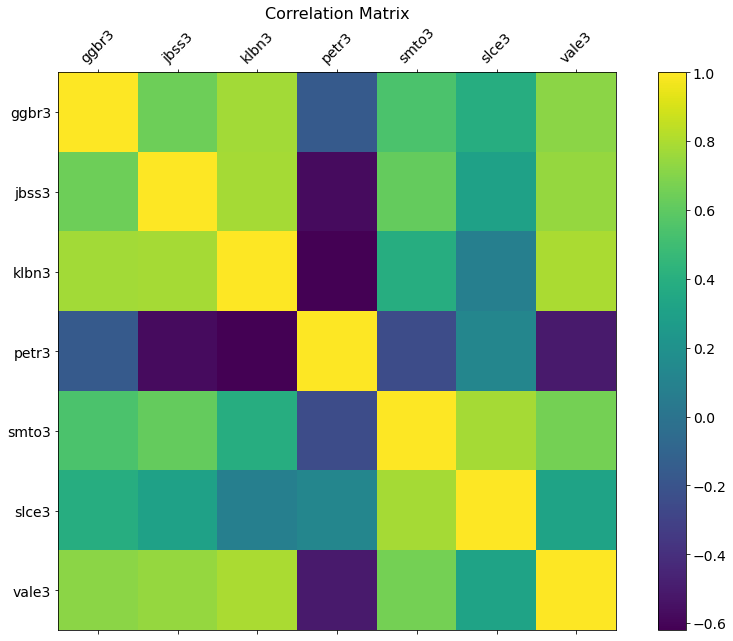

In [3]:
f = plt.figure(figsize=(15, 10))
plt.matshow(asset_yahoo.corr(), fignum=f.number)
plt.xticks(range(asset_yahoo.select_dtypes(['number']).shape[1]), asset_yahoo.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(asset_yahoo.select_dtypes(['number']).shape[1]), asset_yahoo.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Variance

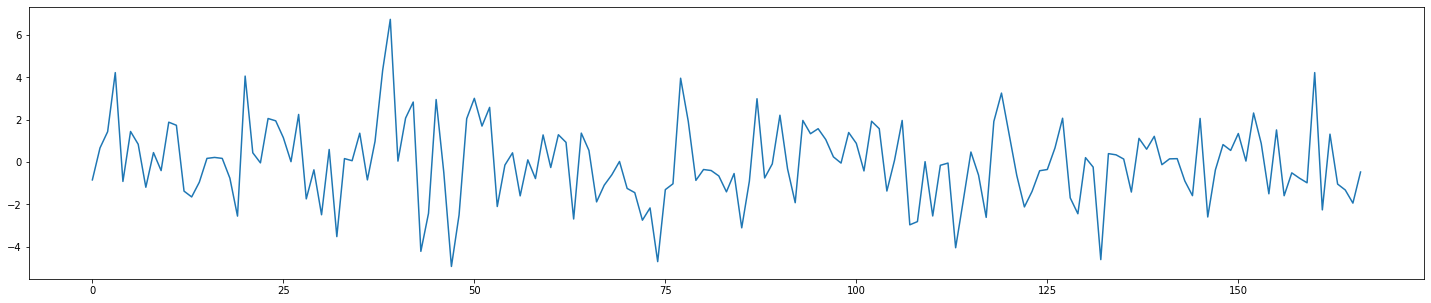

In [61]:
df = np.array
df = asset_yahoo["vale3"]
#df["ggbr"] = cotacao_yahoo["ggbr3"] 
df = np.diff(df)

plt.figure(figsize=(25, 5))
plt.plot(df)

# Time series decomposition

In [266]:
#Decomposição sazonal (period = "analisar a sazonalidade no periodo de X em X dados")
from ast import Mult


ts = asset_yahoo["vale3"]
decomposition = seasonal_decompose(ts, model= 'multiplicative', period = 30, extrapolate_trend='freq')   #multiplicative / addictive

#Trend, seasonality and random noise
trend = decomposition.trend
sazonal = decomposition.seasonal
noise = decomposition.resid

#sazonal.plot(figsize=(25,10))

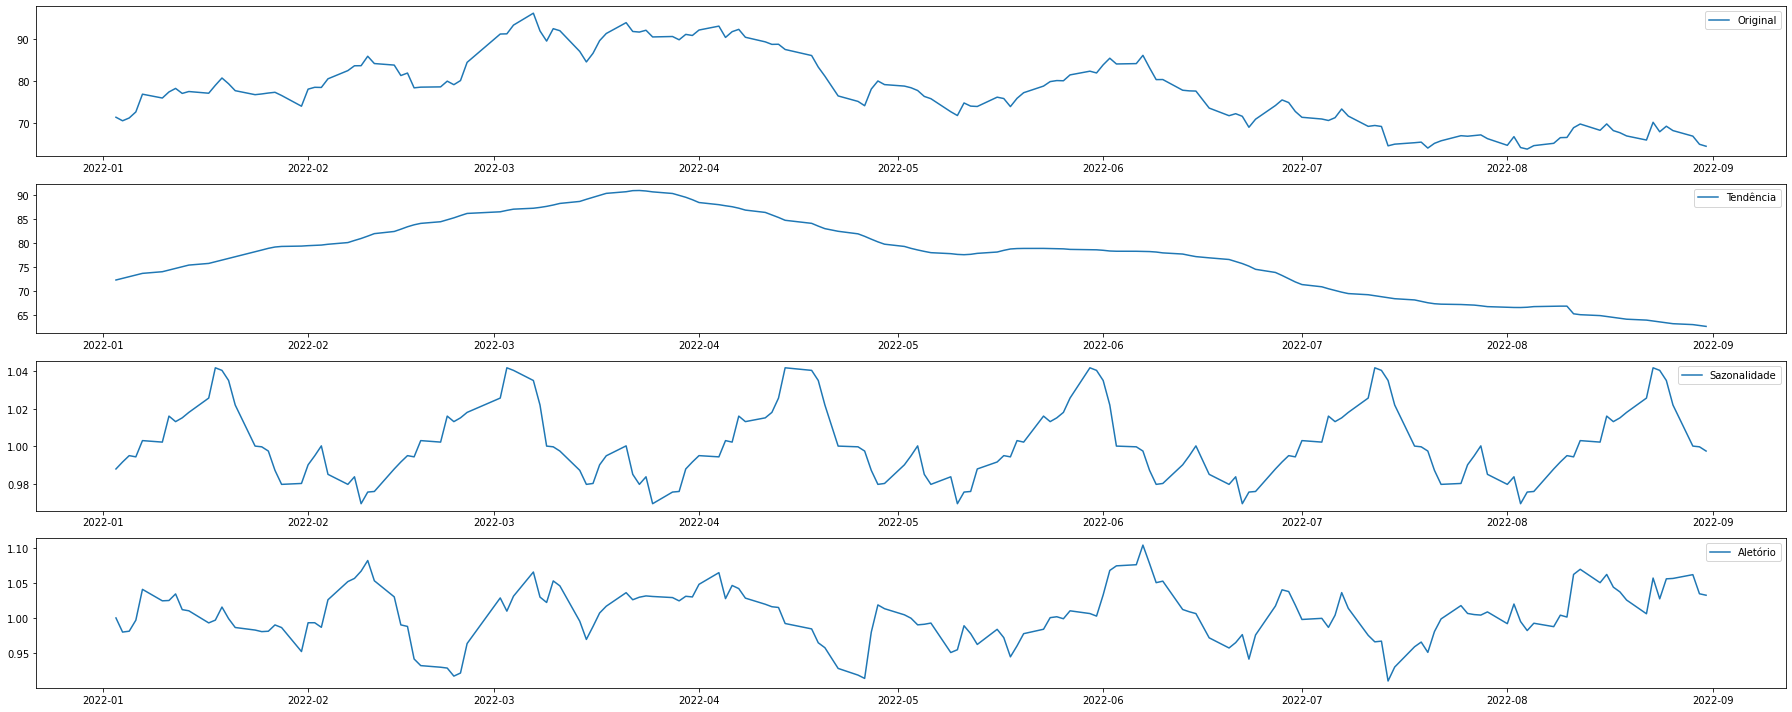

In [267]:
plt.figure(figsize=(25,10))
plt.subplot(4,1,1)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')

# Viz of trend only
plt.subplot(4,1,2)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')

# Viz of seasonality only
plt.subplot(4,1,3)
plt.plot(sazonal, label = 'Sazonalidade')
plt.legend(loc = 'best')

# Viz of random noise only
plt.subplot(4,1,4)
plt.plot(noise, label = 'Aletório')
plt.legend(loc = 'best')
plt.tight_layout()

# Forecasting
### Using the function 'seasonal_decompose' - https://mins.space/blog/2020-07-30-forecasting-through-decomposition/

In [268]:
df_reconstructed = pd.concat(
    [decomposition.seasonal, 
     decomposition.trend,
     decomposition.resid, 
     decomposition.trend * decomposition.resid, 
     decomposition.observed], axis=1)
df_reconstructed.columns = ['seasonal', 'trend', 'remainders', 'seasonal_adj', 'actual_values']
df_reconstructed.tail()

,seasonal,trend,remainders,seasonal_adj,actual_values
Date,,,,,
2022-08-25,1.035067,63.387047,1.055787,66.923208,69.269997
2022-08-26,1.021991,63.199663,1.056364,66.761819,68.230003
2022-08-29,1.000078,63.012280,1.061774,66.904803,66.910004
2022-08-30,0.999693,62.824896,1.034462,64.989948,64.970001
2022-08-31,0.997434,62.637513,1.032383,64.665931,64.500000


In [282]:
#Forecast the seasonal component S^

df_forecast = df_reconstructed.iloc[-10:,:]
df_forecast = df_forecast.set_index(df_forecast.index.shift(15,freq='D'))
df_forecast = df_forecast.drop('actual_values', axis=1)
df_forecast[['trend', 'remainders', 'seasonal_adj']] = np.nan
df_forecast

,seasonal,trend,remainders,seasonal_adj
Date,,,,
2022-09-02,1.015146,NaN,NaN,NaN
2022-09-03,1.018055,NaN,NaN,NaN
2022-09-06,1.025696,NaN,NaN,NaN
2022-09-07,1.041842,NaN,NaN,NaN
2022-09-08,1.040465,NaN,NaN,NaN
2022-09-09,1.035067,NaN,NaN,NaN
2022-09-10,1.021991,NaN,NaN,NaN
2022-09-13,1.000078,NaN,NaN,NaN
2022-09-14,0.999693,NaN,NaN,NaN


In [283]:
#forecast the seasonal component A^

df_forecast['trend'] = df_reconstructed.loc[df_reconstructed.index[-1], 'trend']
df_forecast['remainders'] = df_reconstructed.loc[df_reconstructed.index[-1], 'remainders']
df_forecast['seasonal_adj'] = df_forecast['trend'] * df_forecast['remainders']
df_forecast['forecast'] = df_forecast['seasonal_adj'] * df_forecast['seasonal']
df_forecast

,seasonal,trend,remainders,seasonal_adj,forecast
Date,,,,,
2022-09-02,1.015146,62.637513,1.032383,64.665931,65.645332
2022-09-03,1.018055,62.637513,1.032383,64.665931,65.833443
2022-09-06,1.025696,62.637513,1.032383,64.665931,66.327616
2022-09-07,1.041842,62.637513,1.032383,64.665931,67.371681
2022-09-08,1.040465,62.637513,1.032383,64.665931,67.282636
2022-09-09,1.035067,62.637513,1.032383,64.665931,66.933564
2022-09-10,1.021991,62.637513,1.032383,64.665931,66.088024
2022-09-13,1.000078,62.637513,1.032383,64.665931,64.670957
2022-09-14,0.999693,62.637513,1.032383,64.665931,64.646083


In [284]:
df_plot = pd.concat([df_reconstructed, df_forecast], axis=0)

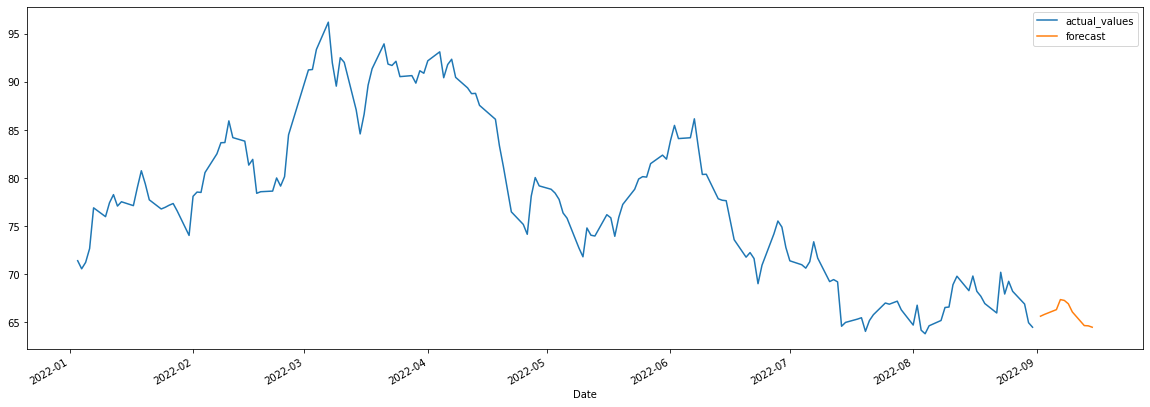

In [285]:
plt.rcParams.update({'figure.figsize': (20,7)})
df_plot[['actual_values', 'forecast']].plot()
#df_plot.iloc[-50:,:][['actual_values', 'forecast']].plot()
plt.show()

c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas_datareader\_utils.py:37: UserWarning: Parsing '13-09-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  end = to_datetime(end)


<AxesSubplot:xlabel='Date'>

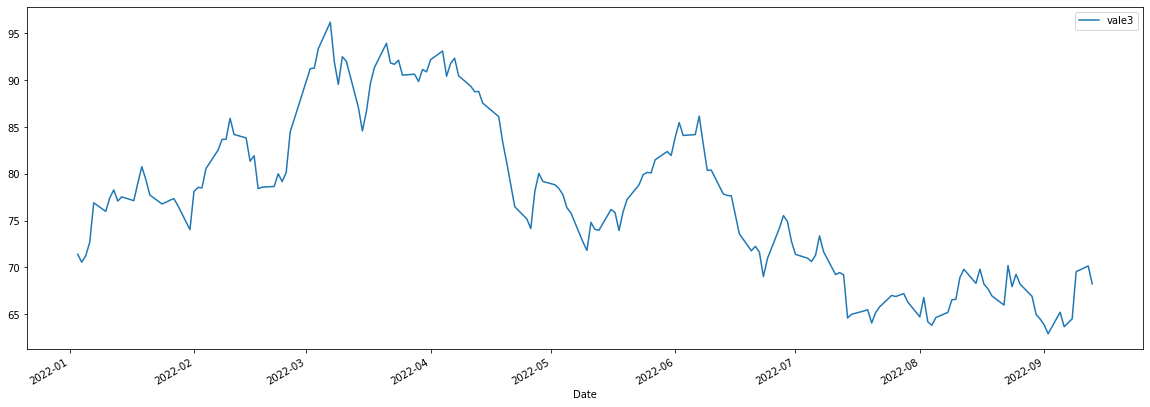

In [273]:
dt_end='13-09-2022'
asset_yahoo = pd.DataFrame()
asset_yahoo["vale3"] = web.DataReader('vale3.SA', data_source='yahoo', start=dt_start, end=dt_end)["Adj Close"]
asset_yahoo.plot(figsize=(20,7))